# Lab 1

## Utils

### Libs

In [1]:
import numpy as np
import torch
from sklearn.metrics import classification_report, accuracy_score
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms

### Constants

In [2]:
DATA_PATH = '.\\fruits-360_dataset\\fruits-360'
PATH_TO_SAVE = '.\\checkpoints\\'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else ' cpu')

### Functions

In [6]:
from torch.optim.lr_scheduler import ExponentialLR


def get_loader(path: str,
               transform,
               batch_size: int = 16,
               shuffle: bool = True):
    image_folder = ImageFolder(root=path, transform=transform)
    loader = torch.utils.data.DataLoader(dataset=image_folder,
                                         batch_size=batch_size,
                                         shuffle=shuffle)
    return loader, image_folder.classes


def train(model: torch.nn.Module,
          data_path: str,
          path_to_save: str,
          model_name: str,
          epochs: int = 10,
          lr: float = 0.1e-3):
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])
                                    ])

    train_dataset, _ = get_loader(f'{data_path}\\Training', batch_size=16, transform=transform)
    test_dataset, targets = get_loader(f'{data_path}\\Test', batch_size=16, transform=transform)

    model.to(device=DEVICE)
    crit_loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ExponentialLR(optimizer, gamma=0.9)
    best_acc = -1
    best_path_model = ''
    for epoch in range(epochs):

        loss_val = 0
        with tqdm(total=len(train_dataset)) as t:
            for i, (img, label) in enumerate(train_dataset):
                img = img.to(DEVICE)

                optimizer.zero_grad()
                output = model(img)

                label = torch.nn.functional.one_hot(label, num_classes=131)
                label = label.to(device=DEVICE, dtype=torch.float)
                loss = crit_loss(label, output)
                loss_val += loss.item()

                loss.backward()
                t.update(1)
                t.set_postfix_str(f"Epoch: {epoch + 1} | Loss: {loss_val / (i + 1)}")

                optimizer.step()
            scheduler.step()

        with tqdm(total=len(test_dataset)) as t:
            labels, predictions = list(), list()
            for i, (img, label) in enumerate(test_dataset):
                labels.extend(label.detach().cpu().tolist())
                img = img.to(DEVICE)

                output = model(img)
                predictions.extend(output.detach().cpu().tolist())
                t.update(1)

            print(classification_report(labels, np.argmax(predictions, axis=1),
                                        target_names=targets, zero_division=0))
            accuracy = accuracy_score(labels, np.argmax(predictions, axis=1))
            if accuracy > best_acc:
                best_path_model = f"{path_to_save}{model_name}_{round(best_acc, 3)}_{epoch + 1}_epochs.pt"
                torch.save(
                    model.state_dict(),
                    best_path_model)
                best_acc = accuracy
    return best_path_model


def validate(model: torch.nn.Module, data_path: str):
    model.to(device=DEVICE)
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x)
                                    ])
    test_dataset, targets = get_loader(f'{data_path}\\Test', batch_size=16, transform=transform)

    with tqdm(total=len(test_dataset)) as t:
        labels, predictions = list(), list()
        for i, (img, label) in enumerate(test_dataset):
            labels.extend(label.detach().cpu().tolist())
            img = img.to(DEVICE)

            output = model(img)
            predictions.extend(output.detach().cpu().tolist())
            t.update(1)

    return classification_report(labels, np.argmax(predictions, axis=1),
                                 target_names=targets,
                                 zero_division=0)


def show_examples(model: torch.nn.Module, path_to_data: str):
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x.permute(2, 0, 1) if x.size(0) == 1 else x),
                                    ])
    test_dataset, targets = get_loader(f'{path_to_data}\\Test', transform=transform)
    images, labels = next(iter(test_dataset))
    predicted_labels = model(images.to(torch.device('cuda')))
    predicted_labels = predicted_labels.argmax(dim=1)
    test_targets = [targets[value] for value in labels]
    predicted_targets = [targets[value] for value in predicted_labels]

    fig, axs = plt.subplots(4, 4, figsize=(15, 15))

    for i, img in enumerate(images):
        np_img = img.permute(1, 2, 0).detach().cpu().numpy()
        axs[i // 4, i % 4].text(0.05, 0.95, f'True: {test_targets[i]}\nPredicted: {predicted_targets[i]}',
                                horizontalalignment='left', verticalalignment='top',
                                transform=axs[i // 4, i % 4].transAxes,
                                bbox={'facecolor': 'green', 'alpha': 0.7, 'pad': 5})
        axs[i // 4, i % 4].imshow(np_img)
    plt.show()

## ResNet50

### Training

In [4]:
from models import ResNet50

resnet50 = ResNet50()
best_path_resnet = train(model=resnet50,
                         data_path=DATA_PATH,
                         path_to_save=PATH_TO_SAVE,
                         model_name='resnet50',
                         epochs=30)

100%|██████████| 1418/1418 [01:21<00:00, 17.46it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.38      0.99      0.55       164
 Apple Crimson Snow       0.47      0.99      0.64       148
     Apple Golden 1       0.88      1.00      0.94       160
     Apple Golden 2       0.35      1.00      0.52       164
     Apple Golden 3       0.00      0.00      0.00       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.00      0.00      0.00       152
        Apple Red 1       0.48      0.78      0.60       164
        Apple Red 2       0.00      0.00      0.00       164
        Apple Red 3       0.29      0.98      0.44       144
Apple Red Delicious       0.00      0.00      0.00       166
 Apple Red Yellow 1       0.71      0.99      0.83       164
 Apple Red Yellow 2       0.90      1.00      0.95       219
            Apricot       0.83      0.96      0.89       164
            Avocado       0.00      0.00      0.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:17<00:00, 18.34it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.49      0.99      0.65       164
 Apple Crimson Snow       0.64      0.95      0.77       148
     Apple Golden 1       0.95      1.00      0.98       160
     Apple Golden 2       0.42      1.00      0.60       164
     Apple Golden 3       0.00      0.00      0.00       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.00      0.00      0.00       152
        Apple Red 1       0.66      0.98      0.79       164
        Apple Red 2       0.47      0.71      0.56       164
        Apple Red 3       0.73      0.99      0.84       144
Apple Red Delicious       0.00      0.00      0.00       166
 Apple Red Yellow 1       0.84      0.98      0.90       164
 Apple Red Yellow 2       0.98      1.00      0.99       219
            Apricot       0.89      1.00      0.94       164
            Avocado       0.00      0.00      0.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:15<00:00, 18.89it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.51      0.99      0.67       164
 Apple Crimson Snow       0.84      0.90      0.87       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       0.97      0.98      0.98       164
     Apple Golden 3       0.44      0.98      0.61       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.95      0.81      0.87       152
        Apple Red 1       0.73      0.98      0.83       164
        Apple Red 2       0.79      0.83      0.81       164
        Apple Red 3       0.71      0.99      0.83       144
Apple Red Delicious       0.00      0.00      0.00       166
 Apple Red Yellow 1       0.99      0.98      0.98       164
 Apple Red Yellow 2       1.00      0.99      1.00       219
            Apricot       0.94      0.99      0.96       164
            Avocado       0.00      0.00      0.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:16<00:00, 18.46it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.84      0.95      0.89       164
 Apple Crimson Snow       0.95      0.95      0.95       148
     Apple Golden 1       0.98      1.00      0.99       160
     Apple Golden 2       0.99      0.97      0.98       164
     Apple Golden 3       0.41      0.99      0.58       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.99      0.90      0.94       152
        Apple Red 1       0.96      0.99      0.97       164
        Apple Red 2       0.83      0.90      0.87       164
        Apple Red 3       1.00      0.94      0.97       144
Apple Red Delicious       0.00      0.00      0.00       166
 Apple Red Yellow 1       0.99      0.95      0.97       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.96      0.99      0.98       164
            Avocado       0.00      0.00      0.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:17<00:00, 18.38it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.90      0.95      0.93       164
 Apple Crimson Snow       0.92      0.95      0.93       148
     Apple Golden 1       1.00      0.99      1.00       160
     Apple Golden 2       0.98      0.99      0.99       164
     Apple Golden 3       0.42      0.98      0.59       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.95      0.96      0.96       152
        Apple Red 1       0.96      0.99      0.98       164
        Apple Red 2       0.94      0.91      0.93       164
        Apple Red 3       0.98      0.97      0.97       144
Apple Red Delicious       0.00      0.00      0.00       166
 Apple Red Yellow 1       0.99      0.93      0.96       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.95      0.99      0.97       164
            Avocado       0.00      0.00      0.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:15<00:00, 18.90it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.85      0.99      0.92       164
 Apple Crimson Snow       1.00      0.93      0.97       148
     Apple Golden 1       0.99      1.00      1.00       160
     Apple Golden 2       0.99      0.97      0.98       164
     Apple Golden 3       0.41      0.99      0.58       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.97      0.98      0.97       152
        Apple Red 1       0.91      0.99      0.95       164
        Apple Red 2       0.93      0.86      0.89       164
        Apple Red 3       0.98      0.91      0.94       144
Apple Red Delicious       0.00      0.00      0.00       166
 Apple Red Yellow 1       0.99      0.94      0.97       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.98      0.99      0.98       164
            Avocado       0.00      0.00      0.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:18<00:00, 18.17it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.84      0.99      0.91       164
 Apple Crimson Snow       0.98      0.95      0.96       148
     Apple Golden 1       0.98      1.00      0.99       160
     Apple Golden 2       0.95      0.99      0.97       164
     Apple Golden 3       0.44      0.96      0.61       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.98      0.97      0.98       152
        Apple Red 1       0.95      0.98      0.96       164
        Apple Red 2       0.94      0.85      0.89       164
        Apple Red 3       0.99      0.97      0.98       144
Apple Red Delicious       0.00      0.00      0.00       166
 Apple Red Yellow 1       0.96      0.94      0.95       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.96      1.00      0.98       164
            Avocado       0.00      0.00      0.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:15<00:00, 18.79it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.93      0.93      0.93       164
 Apple Crimson Snow       0.99      0.94      0.96       148
     Apple Golden 1       0.98      1.00      0.99       160
     Apple Golden 2       0.99      0.96      0.98       164
     Apple Golden 3       0.43      0.99      0.60       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.97      0.99      0.98       152
        Apple Red 1       0.95      0.97      0.96       164
        Apple Red 2       0.97      0.87      0.92       164
        Apple Red 3       0.99      0.94      0.96       144
Apple Red Delicious       0.00      0.00      0.00       166
 Apple Red Yellow 1       0.99      0.95      0.97       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.98      1.00      0.99       164
            Avocado       0.00      0.00      0.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:15<00:00, 18.90it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.85      0.98      0.91       164
 Apple Crimson Snow       0.97      0.99      0.98       148
     Apple Golden 1       0.99      1.00      1.00       160
     Apple Golden 2       0.99      0.95      0.97       164
     Apple Golden 3       0.42      1.00      0.59       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.97      1.00      0.99       152
        Apple Red 1       0.97      0.98      0.97       164
        Apple Red 2       0.97      0.84      0.90       164
        Apple Red 3       0.99      0.97      0.98       144
Apple Red Delicious       0.00      0.00      0.00       166
 Apple Red Yellow 1       0.99      0.95      0.97       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.97      1.00      0.98       164
            Avocado       0.00      0.00      0.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:18<00:00, 18.04it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.93      0.95      0.94       164
 Apple Crimson Snow       0.99      0.93      0.96       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       0.99      0.98      0.98       164
     Apple Golden 3       0.44      1.00      0.61       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.99      0.99      0.99       152
        Apple Red 1       0.93      0.98      0.96       164
        Apple Red 2       0.92      0.95      0.93       164
        Apple Red 3       0.94      0.98      0.96       144
Apple Red Delicious       0.00      0.00      0.00       166
 Apple Red Yellow 1       1.00      0.96      0.98       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.96      1.00      0.98       164
            Avocado       0.00      0.00      0.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:15<00:00, 18.88it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.90      0.96      0.93       164
 Apple Crimson Snow       0.98      0.95      0.96       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       0.99      0.99      0.99       164
     Apple Golden 3       0.40      1.00      0.58       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.99      0.99      0.99       152
        Apple Red 1       0.94      1.00      0.97       164
        Apple Red 2       0.95      0.92      0.93       164
        Apple Red 3       1.00      0.98      0.99       144
Apple Red Delicious       0.00      0.00      0.00       166
 Apple Red Yellow 1       1.00      0.97      0.98       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.97      1.00      0.98       164
            Avocado       0.90      0.96      0.93       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:15<00:00, 18.87it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.93      0.96      0.94       164
 Apple Crimson Snow       0.99      0.95      0.97       148
     Apple Golden 1       0.98      1.00      0.99       160
     Apple Golden 2       0.92      0.99      0.95       164
     Apple Golden 3       0.45      0.98      0.62       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       1.00      0.96      0.98       152
        Apple Red 1       0.95      0.99      0.97       164
        Apple Red 2       0.94      0.90      0.92       164
        Apple Red 3       0.97      0.97      0.97       144
Apple Red Delicious       0.00      0.00      0.00       166
 Apple Red Yellow 1       0.99      0.98      0.98       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.97      1.00      0.98       164
            Avocado       0.87      1.00      0.93       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:16<00:00, 18.43it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.89      0.97      0.93       164
 Apple Crimson Snow       1.00      0.95      0.98       148
     Apple Golden 1       0.99      1.00      1.00       160
     Apple Golden 2       0.96      1.00      0.98       164
     Apple Golden 3       0.43      0.99      0.60       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.99      0.97      0.98       152
        Apple Red 1       0.95      0.99      0.97       164
        Apple Red 2       0.96      0.91      0.93       164
        Apple Red 3       0.99      0.97      0.98       144
Apple Red Delicious       0.00      0.00      0.00       166
 Apple Red Yellow 1       0.99      0.97      0.98       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.96      0.99      0.98       164
            Avocado       0.90      0.97      0.93       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:16<00:00, 18.60it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.96      0.93      0.94       164
 Apple Crimson Snow       0.99      0.96      0.97       148
     Apple Golden 1       1.00      0.99      0.99       160
     Apple Golden 2       0.98      0.99      0.98       164
     Apple Golden 3       0.44      1.00      0.61       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.99      0.95      0.97       152
        Apple Red 1       0.96      0.99      0.98       164
        Apple Red 2       0.85      0.96      0.91       164
        Apple Red 3       0.99      0.98      0.98       144
Apple Red Delicious       0.00      0.00      0.00       166
 Apple Red Yellow 1       0.99      0.95      0.97       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.98      0.99      0.98       164
            Avocado       0.89      1.00      0.94       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:15<00:00, 18.79it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.82      0.98      0.89       164
 Apple Crimson Snow       0.99      0.96      0.97       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       0.97      0.98      0.98       164
     Apple Golden 3       0.43      0.99      0.60       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.99      0.92      0.96       152
        Apple Red 1       0.98      0.99      0.99       164
        Apple Red 2       0.91      0.88      0.89       164
        Apple Red 3       0.99      0.95      0.97       144
Apple Red Delicious       0.82      0.99      0.90       166
 Apple Red Yellow 1       0.99      0.99      0.99       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.97      1.00      0.98       164
            Avocado       0.91      1.00      0.95       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:20<00:00, 17.72it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.89      0.97      0.93       164
 Apple Crimson Snow       0.99      0.97      0.98       148
     Apple Golden 1       0.99      1.00      0.99       160
     Apple Golden 2       0.98      0.98      0.98       164
     Apple Golden 3       0.44      0.99      0.61       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       1.00      0.95      0.97       152
        Apple Red 1       0.97      0.99      0.98       164
        Apple Red 2       0.88      0.97      0.92       164
        Apple Red 3       0.99      0.93      0.96       144
Apple Red Delicious       0.99      1.00      0.99       166
 Apple Red Yellow 1       1.00      0.96      0.98       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       1.00      0.99      1.00       164
            Avocado       0.88      1.00      0.94       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:15<00:00, 18.80it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.93      0.96      0.95       164
 Apple Crimson Snow       1.00      0.93      0.97       148
     Apple Golden 1       0.99      1.00      0.99       160
     Apple Golden 2       0.98      0.98      0.98       164
     Apple Golden 3       0.43      0.99      0.60       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.99      0.98      0.98       152
        Apple Red 1       0.94      1.00      0.97       164
        Apple Red 2       0.93      0.97      0.95       164
        Apple Red 3       0.99      0.99      0.99       144
Apple Red Delicious       0.96      1.00      0.98       166
 Apple Red Yellow 1       0.99      0.98      0.98       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.97      1.00      0.98       164
            Avocado       0.91      1.00      0.95       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:15<00:00, 18.89it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.97      0.88      0.92       164
 Apple Crimson Snow       0.99      0.98      0.98       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       0.95      0.98      0.96       164
     Apple Golden 3       0.43      0.98      0.60       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.99      0.97      0.98       152
        Apple Red 1       0.97      0.99      0.98       164
        Apple Red 2       0.85      0.98      0.91       164
        Apple Red 3       0.97      0.99      0.98       144
Apple Red Delicious       0.99      1.00      1.00       166
 Apple Red Yellow 1       1.00      0.93      0.97       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.98      1.00      0.99       164
            Avocado       0.95      1.00      0.98       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:19<00:00, 17.85it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.97      0.89      0.93       164
 Apple Crimson Snow       0.99      0.99      0.99       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       0.94      1.00      0.97       164
     Apple Golden 3       0.47      0.94      0.63       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       1.00      0.97      0.98       152
        Apple Red 1       0.99      1.00      1.00       164
        Apple Red 2       0.93      0.90      0.92       164
        Apple Red 3       1.00      0.97      0.98       144
Apple Red Delicious       0.99      1.00      1.00       166
 Apple Red Yellow 1       1.00      0.99      0.99       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.94      1.00      0.97       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:14<00:00, 19.37it/s]

                     precision    recall  f1-score   support

     Apple Braeburn       0.91      0.98      0.94       164
 Apple Crimson Snow       0.99      0.97      0.98       148
     Apple Golden 1       0.99      1.00      1.00       160
     Apple Golden 2       1.00      0.96      0.98       164
     Apple Golden 3       0.47      0.99      0.64       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       1.00      0.95      0.98       152
        Apple Red 1       0.98      0.99      0.98       164
        Apple Red 2       0.92      0.98      0.95       164
        Apple Red 3       0.99      0.99      0.99       144
Apple Red Delicious       0.99      1.00      1.00       166
 Apple Red Yellow 1       0.99      0.98      0.98       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.94      1.00      0.97       164
            Avocado       0.98      1.00      0.99       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:17<00:00, 18.28it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.94      0.94      0.94       164
 Apple Crimson Snow       1.00      1.00      1.00       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       1.00      0.97      0.98       164
     Apple Golden 3       0.47      0.97      0.63       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       1.00      0.95      0.98       152
        Apple Red 1       0.99      0.98      0.99       164
        Apple Red 2       0.88      0.98      0.93       164
        Apple Red 3       1.00      0.94      0.97       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.99      0.99      0.99       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.97      0.99      0.98       164
            Avocado       1.00      0.99      0.99       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:19<00:00, 17.81it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.95      0.99      0.97       164
 Apple Crimson Snow       1.00      0.98      0.99       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       0.99      0.99      0.99       164
     Apple Golden 3       0.49      0.99      0.65       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.99      0.99      0.99       152
        Apple Red 1       0.96      0.99      0.98       164
        Apple Red 2       0.93      0.98      0.96       164
        Apple Red 3       0.99      0.98      0.99       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.99      0.95      0.97       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.98      0.99      0.98       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:15<00:00, 18.86it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.83      1.00      0.91       164
 Apple Crimson Snow       0.99      0.95      0.97       148
     Apple Golden 1       0.99      1.00      1.00       160
     Apple Golden 2       0.99      0.98      0.98       164
     Apple Golden 3       0.48      0.98      0.64       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.99      0.99      0.99       152
        Apple Red 1       0.96      0.99      0.98       164
        Apple Red 2       0.95      0.93      0.94       164
        Apple Red 3       1.00      0.91      0.95       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.99      0.98      0.98       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.99      1.00      1.00       164
            Avocado       0.99      0.99      0.99       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:15<00:00, 18.81it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.95      0.96      0.95       164
 Apple Crimson Snow       0.98      0.97      0.97       148
     Apple Golden 1       0.99      1.00      1.00       160
     Apple Golden 2       0.99      1.00      1.00       164
     Apple Golden 3       0.49      0.94      0.64       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.99      0.97      0.98       152
        Apple Red 1       0.97      0.98      0.98       164
        Apple Red 2       0.90      0.96      0.93       164
        Apple Red 3       1.00      0.99      1.00       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       1.00      0.94      0.97       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.97      1.00      0.98       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:20<00:00, 17.61it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.91      0.98      0.94       164
 Apple Crimson Snow       1.00      0.98      0.99       148
     Apple Golden 1       0.99      1.00      1.00       160
     Apple Golden 2       1.00      0.98      0.99       164
     Apple Golden 3       0.48      1.00      0.65       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.99      0.99      0.99       152
        Apple Red 1       0.99      0.99      0.99       164
        Apple Red 2       0.96      0.93      0.94       164
        Apple Red 3       1.00      0.93      0.96       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.99      0.99      0.99       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       1.00      0.98      0.99       164
            Avocado       1.00      0.99      0.99       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:15<00:00, 18.80it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.93      0.98      0.96       164
 Apple Crimson Snow       0.99      0.95      0.97       148
     Apple Golden 1       0.99      1.00      0.99       160
     Apple Golden 2       0.98      0.99      0.99       164
     Apple Golden 3       0.48      0.97      0.64       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       1.00      1.00      1.00       152
        Apple Red 1       0.96      1.00      0.98       164
        Apple Red 2       0.99      0.93      0.96       164
        Apple Red 3       1.00      0.99      0.99       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.99      0.98      0.99       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.97      1.00      0.98       164
            Avocado       0.99      1.00      0.99       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:18<00:00, 18.15it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.98      0.97      0.97       164
 Apple Crimson Snow       0.99      0.98      0.98       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       0.99      0.99      0.99       164
     Apple Golden 3       0.49      0.99      0.66       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       1.00      0.98      0.99       152
        Apple Red 1       0.98      0.98      0.98       164
        Apple Red 2       0.93      0.99      0.96       164
        Apple Red 3       0.99      1.00      1.00       144
Apple Red Delicious       0.99      1.00      0.99       166
 Apple Red Yellow 1       1.00      0.98      0.99       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.98      1.00      0.99       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:17<00:00, 18.37it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.85      0.99      0.92       164
 Apple Crimson Snow       0.96      0.91      0.94       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       0.99      0.99      0.99       164
     Apple Golden 3       0.48      0.98      0.64       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       1.00      0.96      0.98       152
        Apple Red 1       0.91      1.00      0.95       164
        Apple Red 2       0.95      0.94      0.94       164
        Apple Red 3       0.99      0.97      0.98       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.99      0.99      0.99       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.98      1.00      0.99       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:15<00:00, 18.74it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.93      0.98      0.96       164
 Apple Crimson Snow       0.99      0.99      0.99       148
     Apple Golden 1       0.99      1.00      1.00       160
     Apple Golden 2       0.97      1.00      0.98       164
     Apple Golden 3       0.49      0.97      0.65       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.99      0.97      0.98       152
        Apple Red 1       0.98      0.99      0.98       164
        Apple Red 2       0.92      0.93      0.92       164
        Apple Red 3       1.00      0.98      0.99       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       1.00      0.93      0.97       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.98      1.00      0.99       164
            Avocado       0.98      0.99      0.99       143
       Avocado ripe    

100%|██████████| 1418/1418 [01:18<00:00, 17.96it/s]

                     precision    recall  f1-score   support

     Apple Braeburn       0.84      1.00      0.91       164
 Apple Crimson Snow       1.00      0.97      0.98       148
     Apple Golden 1       0.98      1.00      0.99       160
     Apple Golden 2       0.98      1.00      0.99       164
     Apple Golden 3       0.49      0.96      0.65       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.99      1.00      0.99       152
        Apple Red 1       0.98      0.99      0.98       164
        Apple Red 2       0.99      0.85      0.91       164
        Apple Red 3       0.99      0.99      0.99       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.99      0.99      0.99       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.99      1.00      1.00       164
            Avocado       1.00      0.99      0.99       143
       Avocado ripe    

### Validate

In [16]:
checkpoint = torch.load(best_path_resnet)
resnet50.load_state_dict(checkpoint)
validate(resnet50, DATA_PATH)

100%|██████████| 1418/1418 [01:11<00:00, 19.75it/s]
C:\MySpace\Programs\anaconda3\envs\cvenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\MySpace\Programs\anaconda3\envs\cvenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\MySpace\Programs\anaconda3\envs\cvenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

'                     precision    recall  f1-score   support\n\n     Apple Braeburn       0.90      0.99      0.94       164\n Apple Crimson Snow       0.97      0.96      0.97       148\n     Apple Golden 1       1.00      1.00      1.00       160\n     Apple Golden 2       0.98      0.99      0.98       164\n     Apple Golden 3       0.48      0.98      0.65       161\n Apple Granny Smith       0.00      0.00      0.00       164\n    Apple Pink Lady       0.99      0.99      0.99       152\n        Apple Red 1       0.96      1.00      0.98       164\n        Apple Red 2       0.97      0.94      0.95       164\n        Apple Red 3       1.00      0.95      0.98       144\nApple Red Delicious       0.99      1.00      1.00       166\n Apple Red Yellow 1       0.99      0.97      0.98       164\n Apple Red Yellow 2       1.00      1.00      1.00       219\n            Apricot       0.93      1.00      0.96       164\n            Avocado       0.99      1.00      1.00       143\n     

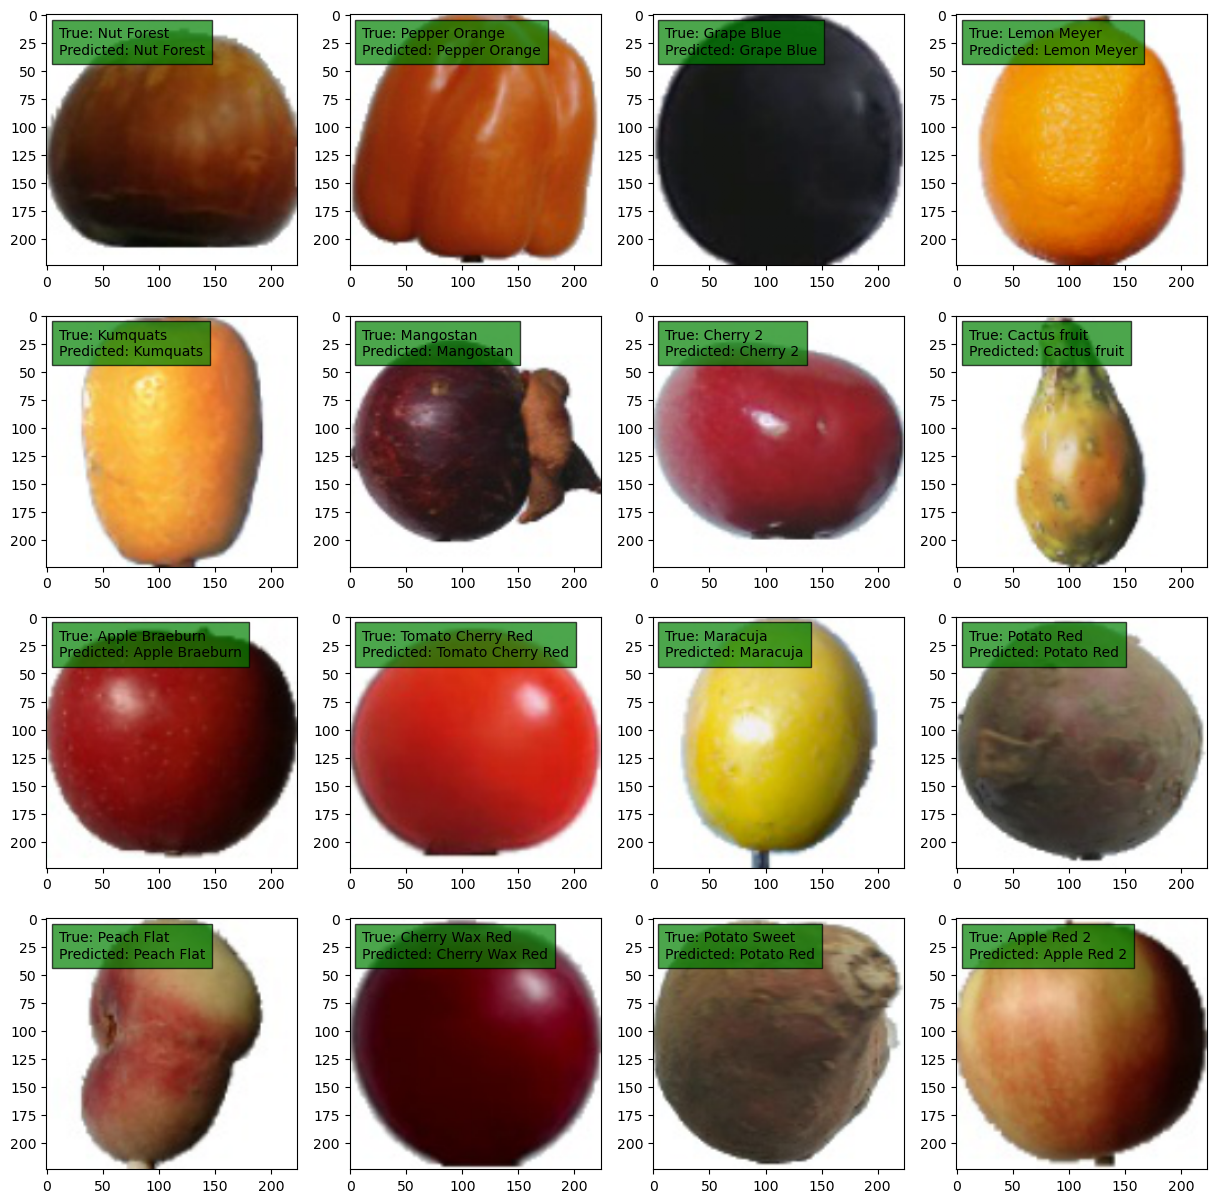

In [17]:
show_examples(model=resnet50, path_to_data=DATA_PATH)

## ConvNext

### Training

In [22]:
from models import ConvNext

conv_next = ConvNext()

best_path_conv_next = train(model=conv_next,
                            data_path=DATA_PATH,
                            path_to_save=PATH_TO_SAVE,
                            model_name='ConvNext',
                            epochs=20,
                            lr=0.1e-2)

100%|██████████| 1418/1418 [03:26<00:00,  6.71it/s]

                     precision    recall  f1-score   support

     Apple Braeburn       0.40      0.99      0.57       164
 Apple Crimson Snow       0.50      0.89      0.64       148
     Apple Golden 1       0.98      1.00      0.99       160
     Apple Golden 2       0.95      1.00      0.98       164
     Apple Golden 3       0.55      0.99      0.71       161
 Apple Granny Smith       0.77      0.99      0.87       164
    Apple Pink Lady       0.74      0.98      0.85       152
        Apple Red 1       0.91      0.98      0.94       164
        Apple Red 2       0.54      0.81      0.65       164
        Apple Red 3       0.00      0.00      0.00       144
Apple Red Delicious       0.87      1.00      0.93       166
 Apple Red Yellow 1       0.71      0.98      0.82       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.84      1.00      0.91       164
            Avocado       0.98      1.00      0.99       143
       Avocado ripe    

100%|██████████| 1418/1418 [03:32<00:00,  6.76it/s]

                     precision    recall  f1-score   support

     Apple Braeburn       0.38      1.00      0.56       164
 Apple Crimson Snow       0.62      0.97      0.76       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       1.00      1.00      1.00       164
     Apple Golden 3       0.49      1.00      0.66       161
 Apple Granny Smith       0.91      0.96      0.93       164
    Apple Pink Lady       0.97      1.00      0.98       152
        Apple Red 1       0.78      0.99      0.87       164
        Apple Red 2       0.70      0.76      0.73       164
        Apple Red 3       0.00      0.00      0.00       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.81      0.99      0.89       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.78      1.00      0.88       164
            Avocado       0.99      1.00      1.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [03:30<00:00,  6.75it/s]

                     precision    recall  f1-score   support

     Apple Braeburn       0.39      1.00      0.56       164
 Apple Crimson Snow       0.57      0.99      0.72       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       0.99      1.00      1.00       164
     Apple Golden 3       0.64      1.00      0.78       161
 Apple Granny Smith       0.77      0.99      0.87       164
    Apple Pink Lady       0.91      1.00      0.95       152
        Apple Red 1       0.93      1.00      0.96       164
        Apple Red 2       0.62      0.78      0.69       164
        Apple Red 3       0.00      0.00      0.00       144
Apple Red Delicious       0.97      1.00      0.98       166
 Apple Red Yellow 1       0.89      0.99      0.94       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.72      0.99      0.83       164
            Avocado       0.97      1.00      0.99       143
       Avocado ripe    

100%|██████████| 1418/1418 [03:29<00:00,  6.76it/s]

                     precision    recall  f1-score   support

     Apple Braeburn       0.39      1.00      0.56       164
 Apple Crimson Snow       0.67      0.99      0.80       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       1.00      0.98      0.99       164
     Apple Golden 3       0.53      1.00      0.69       161
 Apple Granny Smith       0.87      0.90      0.88       164
    Apple Pink Lady       0.93      0.99      0.96       152
        Apple Red 1       0.92      0.99      0.95       164
        Apple Red 2       0.63      0.76      0.69       164
        Apple Red 3       0.00      0.00      0.00       144
Apple Red Delicious       0.96      1.00      0.98       166
 Apple Red Yellow 1       0.87      1.00      0.93       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.71      1.00      0.83       164
            Avocado       0.98      1.00      0.99       143
       Avocado ripe    

100%|██████████| 1418/1418 [03:30<00:00,  6.78it/s]

                     precision    recall  f1-score   support

     Apple Braeburn       0.40      1.00      0.57       164
 Apple Crimson Snow       1.00      0.97      0.98       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       1.00      0.99      1.00       164
     Apple Golden 3       0.64      1.00      0.78       161
 Apple Granny Smith       0.91      0.98      0.94       164
    Apple Pink Lady       0.92      0.99      0.95       152
        Apple Red 1       0.87      0.99      0.93       164
        Apple Red 2       0.60      0.74      0.67       164
        Apple Red 3       0.00      0.00      0.00       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.91      1.00      0.95       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.89      1.00      0.94       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [03:24<00:00,  6.96it/s]

                     precision    recall  f1-score   support

     Apple Braeburn       0.40      1.00      0.57       164
 Apple Crimson Snow       0.99      1.00      1.00       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       1.00      1.00      1.00       164
     Apple Golden 3       0.82      1.00      0.90       161
 Apple Granny Smith       0.79      0.98      0.88       164
    Apple Pink Lady       0.93      0.99      0.96       152
        Apple Red 1       0.88      0.99      0.93       164
        Apple Red 2       0.63      0.80      0.70       164
        Apple Red 3       0.00      0.00      0.00       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.77      1.00      0.87       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.76      1.00      0.86       164
            Avocado       0.98      1.00      0.99       143
       Avocado ripe    

100%|██████████| 1418/1418 [03:29<00:00,  6.77it/s]

                     precision    recall  f1-score   support

     Apple Braeburn       0.40      1.00      0.57       164
 Apple Crimson Snow       1.00      0.99      1.00       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       0.99      1.00      0.99       164
     Apple Golden 3       0.81      1.00      0.90       161
 Apple Granny Smith       0.85      0.98      0.91       164
    Apple Pink Lady       0.99      0.99      0.99       152
        Apple Red 1       0.93      0.99      0.96       164
        Apple Red 2       0.61      0.82      0.70       164
        Apple Red 3       0.00      0.00      0.00       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.94      1.00      0.97       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.84      1.00      0.91       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [03:29<00:00,  6.59it/s]

                     precision    recall  f1-score   support

     Apple Braeburn       0.40      1.00      0.58       164
 Apple Crimson Snow       1.00      1.00      1.00       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       0.99      0.99      0.99       164
     Apple Golden 3       0.81      1.00      0.90       161
 Apple Granny Smith       0.77      1.00      0.87       164
    Apple Pink Lady       0.95      0.99      0.97       152
        Apple Red 1       0.87      1.00      0.93       164
        Apple Red 2       0.64      0.81      0.71       164
        Apple Red 3       0.00      0.00      0.00       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.90      1.00      0.95       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.82      1.00      0.90       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [03:29<00:00,  6.61it/s]

                     precision    recall  f1-score   support

     Apple Braeburn       0.43      1.00      0.61       164
 Apple Crimson Snow       1.00      0.99      1.00       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       1.00      1.00      1.00       164
     Apple Golden 3       0.77      1.00      0.87       161
 Apple Granny Smith       0.85      0.99      0.91       164
    Apple Pink Lady       0.97      1.00      0.98       152
        Apple Red 1       0.91      1.00      0.95       164
        Apple Red 2       0.63      0.84      0.72       164
        Apple Red 3       0.00      0.00      0.00       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.92      1.00      0.96       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.77      1.00      0.87       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [03:29<00:00,  6.72it/s]

                     precision    recall  f1-score   support

     Apple Braeburn       0.44      1.00      0.61       164
 Apple Crimson Snow       1.00      0.99      1.00       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       1.00      0.99      1.00       164
     Apple Golden 3       0.76      1.00      0.86       161
 Apple Granny Smith       0.75      0.99      0.86       164
    Apple Pink Lady       0.96      0.99      0.97       152
        Apple Red 1       0.95      1.00      0.97       164
        Apple Red 2       0.59      0.87      0.70       164
        Apple Red 3       0.00      0.00      0.00       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.86      1.00      0.92       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.84      0.99      0.91       164
            Avocado       0.99      1.00      1.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [03:29<00:00,  6.76it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.42      1.00      0.59       164
 Apple Crimson Snow       1.00      0.99      1.00       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       1.00      1.00      1.00       164
     Apple Golden 3       0.74      1.00      0.85       161
 Apple Granny Smith       0.84      0.99      0.91       164
    Apple Pink Lady       0.94      0.99      0.96       152
        Apple Red 1       0.95      0.99      0.97       164
        Apple Red 2       0.62      0.82      0.71       164
        Apple Red 3       0.00      0.00      0.00       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.86      1.00      0.92       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.83      1.00      0.91       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [03:30<00:00,  6.74it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.44      1.00      0.61       164
 Apple Crimson Snow       1.00      1.00      1.00       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       1.00      1.00      1.00       164
     Apple Golden 3       0.80      1.00      0.89       161
 Apple Granny Smith       0.74      1.00      0.85       164
    Apple Pink Lady       0.99      0.97      0.98       152
        Apple Red 1       0.96      0.99      0.98       164
        Apple Red 2       0.55      0.88      0.68       164
        Apple Red 3       0.00      0.00      0.00       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.89      1.00      0.94       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.87      1.00      0.93       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

100%|██████████| 1418/1418 [03:26<00:00,  6.88it/s]


                     precision    recall  f1-score   support

     Apple Braeburn       0.40      1.00      0.58       164
 Apple Crimson Snow       1.00      1.00      1.00       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       1.00      1.00      1.00       164
     Apple Golden 3       0.73      1.00      0.85       161
 Apple Granny Smith       0.79      0.99      0.88       164
    Apple Pink Lady       0.96      0.99      0.98       152
        Apple Red 1       0.86      1.00      0.92       164
        Apple Red 2       0.60      0.87      0.71       164
        Apple Red 3       0.00      0.00      0.00       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       0.89      1.00      0.94       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.81      1.00      0.90       164
            Avocado       0.99      1.00      1.00       143
       Avocado ripe    

 14%|█▍        | 609/4231 [01:34<09:19,  6.47it/s, Epoch: 14 | Loss: 3.937814250172457] 

KeyboardInterrupt



### Validate

In [23]:
checkpoint = torch.load('checkpoints/ConvNext_0.945_10_epochs.pt')
conv_next = ConvNext()
conv_next.load_state_dict(checkpoint)
validate(model=conv_next,
         data_path=DATA_PATH)

100%|██████████| 1418/1418 [03:28<00:00,  6.79it/s]


'                     precision    recall  f1-score   support\n\n     Apple Braeburn       0.52      0.99      0.68       164\n Apple Crimson Snow       1.00      0.91      0.95       148\n     Apple Golden 1       0.99      1.00      0.99       160\n     Apple Golden 2       0.98      0.96      0.97       164\n     Apple Golden 3       0.71      1.00      0.83       161\n Apple Granny Smith       0.86      0.97      0.91       164\n    Apple Pink Lady       0.89      0.87      0.88       152\n        Apple Red 1       0.98      0.76      0.86       164\n        Apple Red 2       0.47      0.96      0.63       164\n        Apple Red 3       0.00      0.00      0.00       144\nApple Red Delicious       1.00      0.99      1.00       166\n Apple Red Yellow 1       0.71      1.00      0.83       164\n Apple Red Yellow 2       1.00      1.00      1.00       219\n            Apricot       0.74      1.00      0.85       164\n            Avocado       0.94      0.98      0.96       143\n     

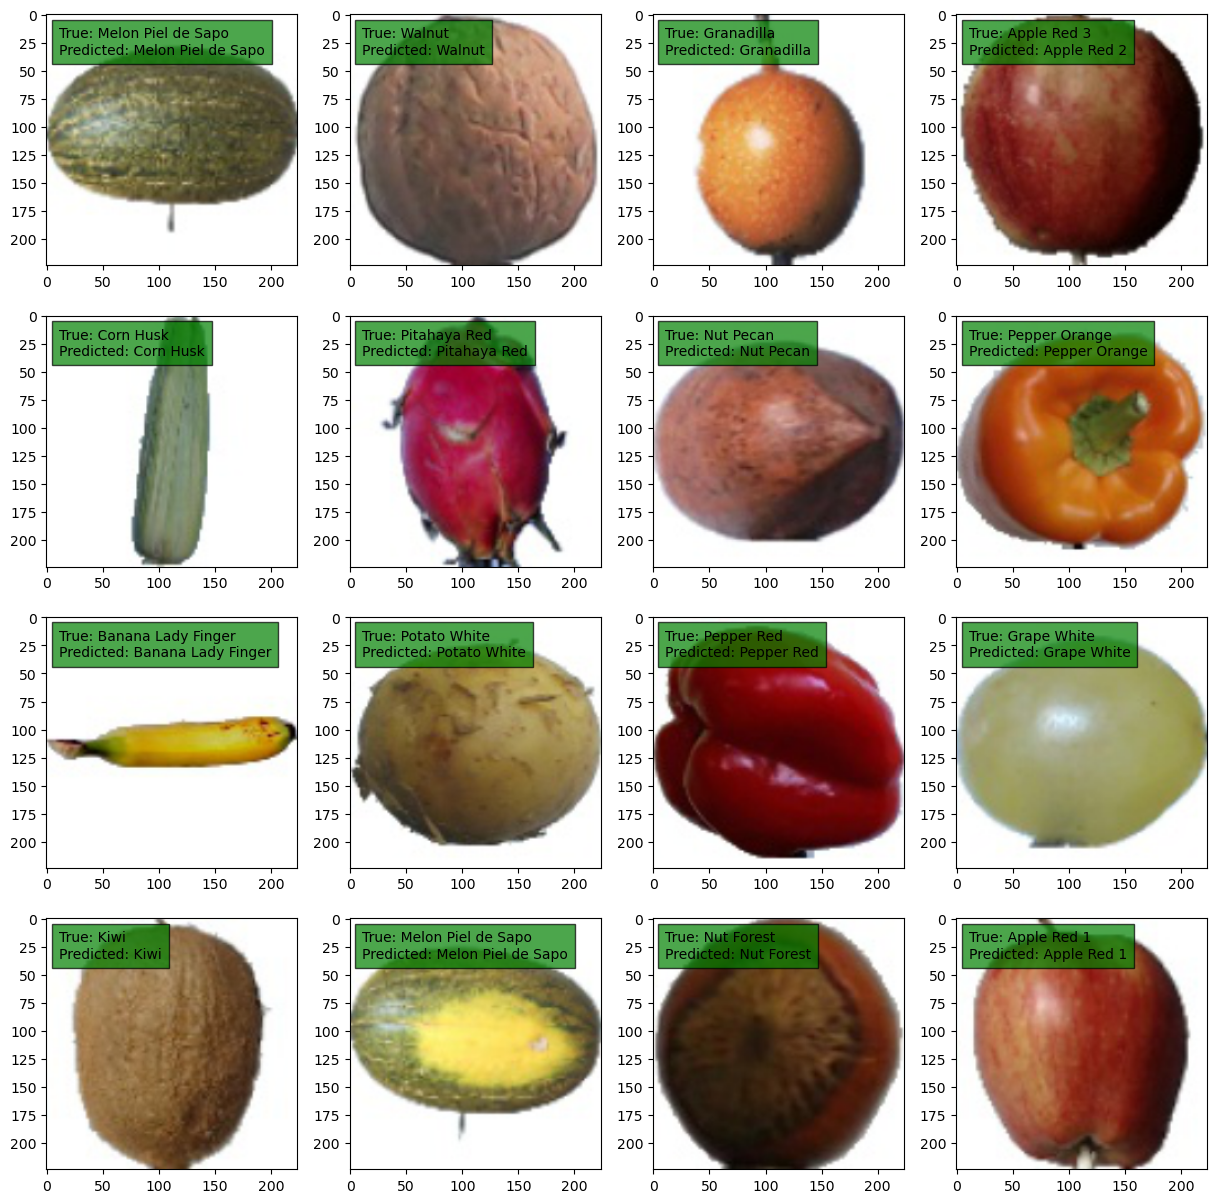

In [24]:
show_examples(model=conv_next.to(device='cuda'), path_to_data=DATA_PATH)